# Breaking CAPTCHAs with PyTorch

This notebook re-implements the Lab 2 TensorFlow/Keras CNN in **PyTorch**, then repeats the same training + evaluation workflow.

**Architecture (same as TF):**
- Conv2d(1→20, 5×5, padding=2) + ReLU + MaxPool(2)
- Conv2d(20→50, 5×5, padding=2) + ReLU + MaxPool(2)
- Flatten (5×5×50 = 1250)
- FC 1250→500 (ReLU)
- FC 500→n_classes

---

In [13]:
# If you're in Colab, run installs once:
# %pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install -q matplotlib scikit-learn imutils "opencv-python>=4.0"

import os, glob, pickle, math
from pprint import pprint

import cv2
import numpy as np
import imutils
from imutils import paths
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# IMPORTANT: make sure lab_2_helpers.py is in the same directory
from lab_2_helpers import *
print("torch:", torch.__version__)


torch: 2.9.0+cpu


In [14]:
!tar -xJf captcha-images.tar.xz


## 1) Load dataset + labels from filenames

In [15]:
# If your dataset is still archived, extract it first:
# !tar -xJf captcha-images.tar.xz

CAPTCHA_IMAGE_FOLDER = "./captcha-images"
assert os.path.exists(CAPTCHA_IMAGE_FOLDER), "captcha-images folder not found. Extract captcha-images.tar.xz first."

captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
pprint(captcha_image_paths[:10])

def extract_captcha_text(image_path):
    image_file_name = os.path.basename(image_path)
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(p) for p in captcha_image_paths]
pprint(captcha_texts[:10])


['./captcha-images/C4F7.png',
 './captcha-images/7VWM.png',
 './captcha-images/B4FA.png',
 './captcha-images/3EFX.png',
 './captcha-images/C2Z6.png',
 './captcha-images/2QP5.png',
 './captcha-images/G9ES.png',
 './captcha-images/3DDY.png',
 './captcha-images/B7N3.png',
 './captcha-images/5WGG.png']
['C4F7', '7VWM', 'B4FA', '3EFX', 'C2Z6', '2QP5', 'G9ES', '3DDY', 'B7N3', '5WGG']


## 2) Preprocess CAPTCHAs (grayscale + padding)

Figure(2000x500)


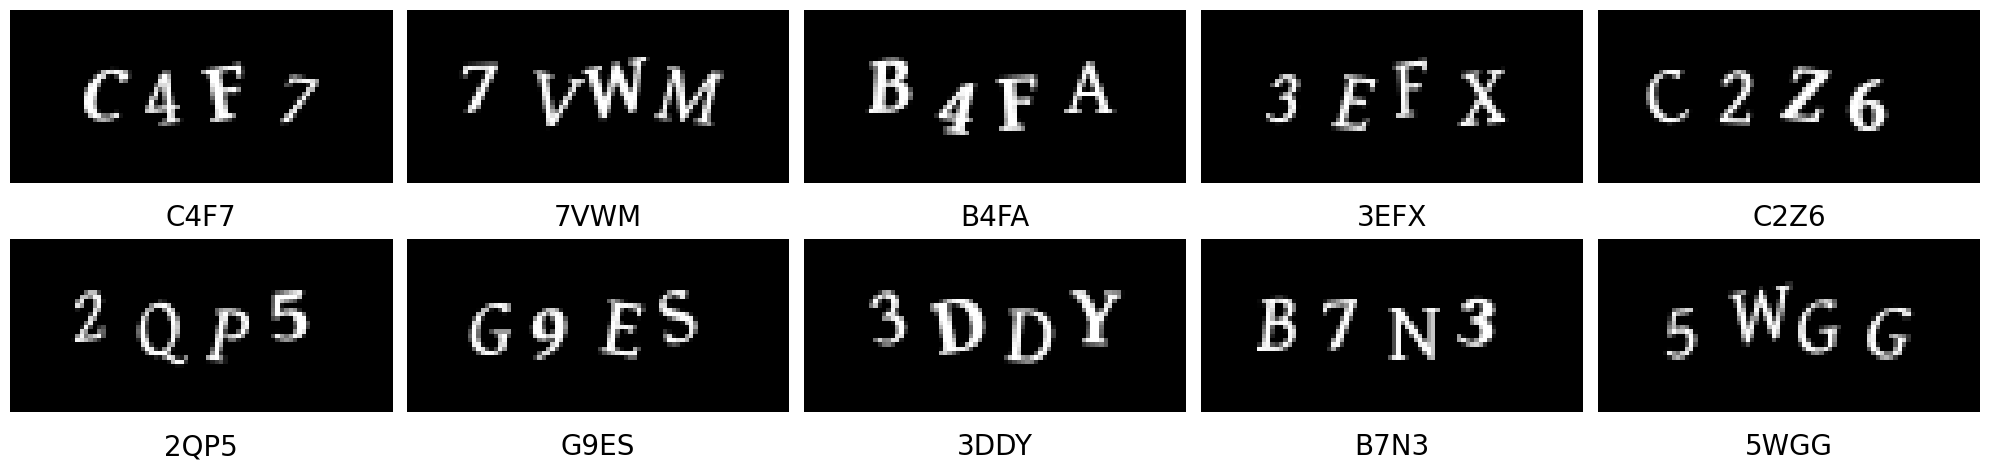

In [16]:
def load_transform_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_padded = cv2.copyMakeBorder(
        image_gray, 8, 8, 8, 8, borderType=cv2.BORDER_REPLICATE
    )
    return image_padded

captcha_images = [load_transform_image(p) for p in captcha_image_paths]

k = min(10, len(captcha_images))
print_images(captcha_images[:k], n_rows=2, texts=captcha_texts[:k])


## 3) Train/Val/Test split (same idea as TF)

In [17]:
TVT_SPLIT_SEED = 31528476

captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED, shuffle=True
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))


Train-validation: 908
Test: 228


## 4) Character extraction (same as TF)

In [18]:
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"
LABELS_PATH = "./labels_pytorch.pkl"

def extract_chars(image):
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    char_regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w / h > 1.25:
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, half_width, h))
        else:
            char_regions.append((x, y, w, h))

    if len(char_regions) != 4:
        return None

    char_regions.sort(key=lambda x: x[0])

    char_images = []
    for x, y, w, h in char_regions:
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        char_images.append(char_image)
    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    for char_image, char in zip(char_images, captcha_text):
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)

        char_count = char_counts.get(char, 1)
        char_image_path = os.path.join(save_path, f"{char_count}.png")
        cv2.imwrite(char_image_path, char_image)

        char_counts[char] = char_count + 1

FORCE_EXTRACT_CHAR = False

char_counts = {}
if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        char_images = extract_chars(captcha_image)
        if char_images is None:
            continue
        save_chars(char_images, captcha_text, CHAR_IMAGE_FOLDER, char_counts)

print("Char folder:", CHAR_IMAGE_FOLDER, "exists?", os.path.exists(CHAR_IMAGE_FOLDER))


Char folder: ./char-images-31528476 exists? True


## 5) Build PyTorch dataset (20×20 grayscale, normalized)

In [19]:
def make_feature(image):
    image_resized = resize_to_fit(image, 20, 20)  # from lab_2_helpers
    return image_resized  # still 2D uint8

class CharDataset(Dataset):
    def __init__(self, image_paths, labels, label_to_idx):
        self.image_paths = list(image_paths)
        self.labels = list(labels)
        self.label_to_idx = dict(label_to_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        p = self.image_paths[idx]
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(p)
        img = make_feature(img)             # 20x20
        img = img.astype("float32") / 255.0 # [0,1]
        x = torch.from_numpy(img).unsqueeze(0)  # (1,20,20)
        y = self.label_to_idx[self.labels[idx]]
        return x, y

# collect char image paths + labels
char_image_paths = list(paths.list_images(CHAR_IMAGE_FOLDER))
char_labels = [p.split(os.path.sep)[-2] for p in char_image_paths]
classes = sorted(set(char_labels))
label_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_label = {i:c for c,i in label_to_idx.items()}
n_classes = len(classes)

print("n_classes:", n_classes, "classes sample:", classes[:10])

# Train/validation split on character images
X_train_p, X_val_p, y_train_p, y_val_p = train_test_split(
    char_image_paths, char_labels, test_size=0.25, random_state=955996, shuffle=True, stratify=char_labels
)

train_ds = CharDataset(X_train_p, y_train_p, label_to_idx)
val_ds   = CharDataset(X_val_p, y_val_p, label_to_idx)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

with open(LABELS_PATH, "wb") as f:
    pickle.dump({"label_to_idx": label_to_idx, "idx_to_label": idx_to_label}, f)


n_classes: 32 classes sample: ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B']


## 6) Define CNN in PyTorch (same as TF)

In [20]:
class CaptchaCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5 * 5 * 50, 500)
        self.fc2 = nn.Linear(500, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B,20,10,10)
        x = self.pool(F.relu(self.conv2(x)))  # (B,50,5,5)
        x = torch.flatten(x, 1)               # (B,1250)
        x = F.relu(self.fc1(x))               # (B,500)
        x = self.fc2(x)                       # logits
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CaptchaCNN(n_classes).to(device)
print("device:", device)
print(model)


device: cpu
CaptchaCNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=32, bias=True)
)


## 7) Train (CrossEntropyLoss + Adam)

In [21]:
N_EPOCHS = 10
MODEL_WEIGHTS_PATH = "./captcha-model-pytorch.pth"
FORCE_TRAINING = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def eval_loader(loader):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return total_loss / max(total, 1), correct / max(total, 1)

if FORCE_TRAINING or not os.path.exists(MODEL_WEIGHTS_PATH):
    for epoch in range(1, N_EPOCHS + 1):
        model.train()
        running_loss, total, correct = 0.0, 0, 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)

        train_loss = running_loss / max(total, 1)
        train_acc = correct / max(total, 1)

        val_loss, val_acc = eval_loader(val_loader)
        print(f"Epoch {epoch:2d}/{N_EPOCHS} | train_loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f}")

    torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
else:
    model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=device))

print("Saved/loaded weights:", MODEL_WEIGHTS_PATH)


Epoch  1/10 | train_loss=2.1418 acc=0.4204 | val_loss=0.5343 acc=0.8722
Epoch  2/10 | train_loss=0.2370 acc=0.9496 | val_loss=0.1258 acc=0.9731
Epoch  3/10 | train_loss=0.0829 acc=0.9877 | val_loss=0.0882 acc=0.9832
Epoch  4/10 | train_loss=0.0508 acc=0.9888 | val_loss=0.0668 acc=0.9854
Epoch  5/10 | train_loss=0.0284 acc=0.9933 | val_loss=0.0628 acc=0.9865
Epoch  6/10 | train_loss=0.0166 acc=0.9966 | val_loss=0.0448 acc=0.9910
Epoch  7/10 | train_loss=0.0079 acc=0.9985 | val_loss=0.0428 acc=0.9910
Epoch  8/10 | train_loss=0.0048 acc=0.9989 | val_loss=0.0488 acc=0.9910
Epoch  9/10 | train_loss=0.0019 acc=1.0000 | val_loss=0.0409 acc=0.9910
Epoch 10/10 | train_loss=0.0007 acc=1.0000 | val_loss=0.0397 acc=0.9910
Saved/loaded weights: ./captcha-model-pytorch.pth


## 8) CAPTCHA-level evaluation (same as TF)

We predict characters, group every 4 into a CAPTCHA string, and compute accuracy on the test split. CAPTCHAs where character extraction fails are marked with `'-'`.

In [22]:
with open(LABELS_PATH, "rb") as f:
    maps = pickle.load(f)
idx_to_label = maps["idx_to_label"]

def predict_char_images(char_images):
    feats = []
    for img in char_images:
        img = make_feature(img).astype("float32") / 255.0
        feats.append(img)
    xb = torch.from_numpy(np.stack(feats, axis=0)).unsqueeze(1).to(device)  # (B,1,20,20)
    model.eval()
    with torch.no_grad():
        logits = model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy().tolist()
    return [idx_to_label[i] for i in preds]

DUMMY_CHAR_IMAGES = [np.zeros((20, 20), dtype=np.uint8) for _ in range(4)]

extract_failed_indices = []
all_char_images = []

for i, captcha_image in enumerate(captcha_images_test):
    chars = extract_chars(captcha_image)
    if chars is None:
        extract_failed_indices.append(i)
        all_char_images.extend(DUMMY_CHAR_IMAGES)
    else:
        all_char_images.extend(chars)

pred_chars = predict_char_images(all_char_images)

preds_test = ["".join(chars) for chars in group_every(pred_chars, 4)]
for i in extract_failed_indices:
    preds_test[i] = "-"

n_test = len(captcha_texts_test)
n_correct = sum(p == a for p, a in zip(preds_test, captcha_texts_test))

print("# of test CAPTCHAs:", n_test)
print("# correctly recognized:", n_correct)
print("Accuracy:", n_correct / n_test)
print("Extraction failures:", len(extract_failed_indices))


# of test CAPTCHAs: 228
# correctly recognized: 218
Accuracy: 0.956140350877193
Extraction failures: 3


## 9) Show a few correct and incorrect predictions

Figure(2000x500)
Figure(2000x600)


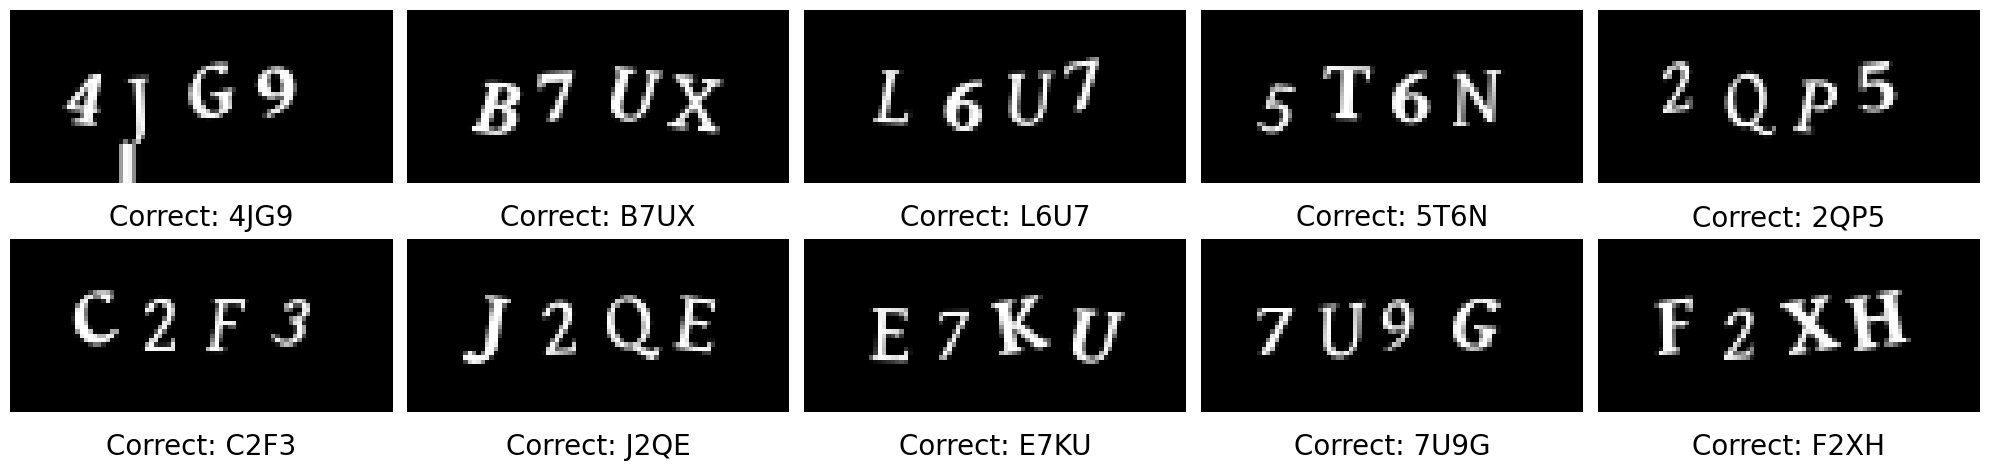

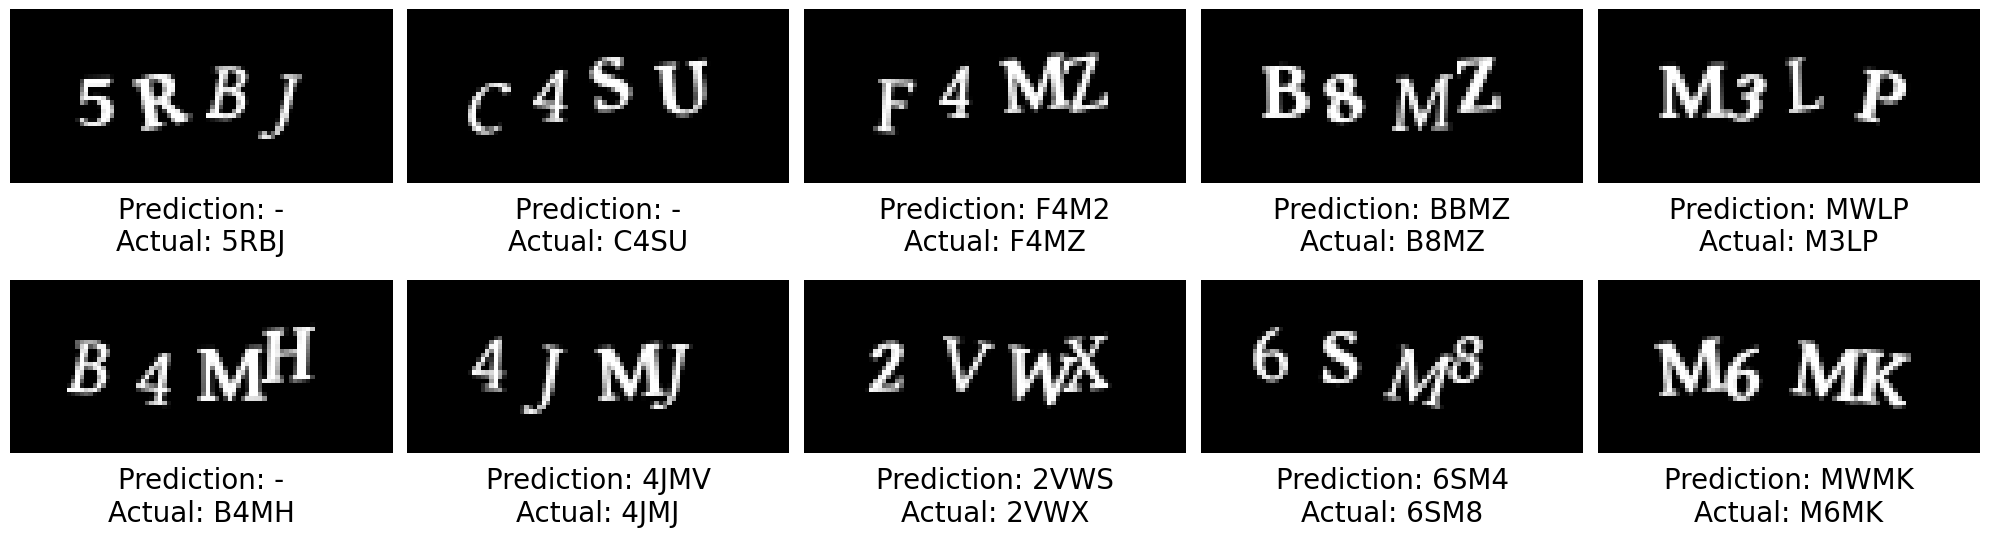

In [23]:
N_DISPLAY_SAMPLES = 10

correct_indices = []
incorrect_indices = []

for i, (pred_text, actual_text) in enumerate(zip(preds_test, captcha_texts_test)):
    if pred_text == actual_text:
        if len(correct_indices) < N_DISPLAY_SAMPLES:
            correct_indices.append(i)
    else:
        if len(incorrect_indices) < N_DISPLAY_SAMPLES:
            incorrect_indices.append(i)

print_images(
    [captcha_images_test[i] for i in correct_indices],
    texts=[f"Correct: {captcha_texts_test[i]}" for i in correct_indices],
    n_rows=2
)

print_images(
    [captcha_images_test[i] for i in incorrect_indices],
    texts=[f"Prediction: {preds_test[i]}\nActual: {captcha_texts_test[i]}" for i in incorrect_indices],
    n_rows=2,
    fig_size=(20, 6),
    text_center=(0.5, -0.25),
)
